<a href="https://colab.research.google.com/github/Lukaid/Fastcampus_Pytorch/blob/main/Seminar_0412_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 감정 분석(Sentiment Analysis)

![2655364B5925AC9606[1].png](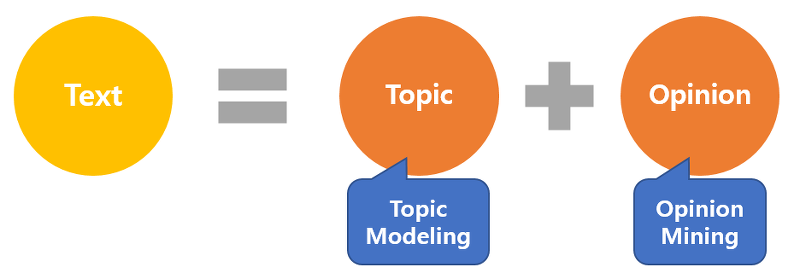)

* 감정 분석의 두가지 방법
  1. 감정 어휘 사전을 이용한 감정 상태 분류
    -  미리 분류해둔 감정어 사전을 통해 분석하고자 하는 텍스트의 단어들을 사전에 기반해 분류하고, 그 감정가를 계산
    - 이 때 사용되는 감정어 사전에는 해당 감정에 해당되는 단어를 미리 정의해둬야 함
  2. 기계학습을 이용한 감정 상태 분류
    - 분석 데이터의 일부를 훈련 데이터로 사용해 그로부터 텍스트의 감정 상태를 분류
    - 이 때 사용되는 훈련 데이터는 사용자가 분류한 감정 **라벨이** 포함되어 있어야 하며,  
이를 **인공 신경망**, 의사 결정 트리 등의 기계 학습 알고리즘을 사용하여 분류

## 본 연구는 **기계학습**을 이용한 감정분석을 수행

#### 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

* https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh


- 참고로 아래의 방법은 colab에서만 동작... windows에서 설치하려면 아주 복잡하여 pass...

In [1]:
!set - x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

     |████████████████████████████████| 19.4MB 49.5MB/s 
     |████████████████████████████████| 460kB 28.8MB/s 
     |████████████████████████████████| 92kB 8.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
/etc/os-release:NAME="Ubuntu"
/etc/os-release:ID=ubuntu
/etc/os-release:ID_LIKE=debian
/etc/os-release:PRET

In [2]:
from konlpy.tag import Mecab

In [3]:
test = Mecab()

test.pos('4월 12일, 물류세미나가 진행됩니다.')

[('4', 'SN'),
 ('월', 'NNBC'),
 ('12', 'SN'),
 ('일', 'NNBC'),
 (',', 'SC'),
 ('물류', 'NNP'),
 ('세미나', 'NNG'),
 ('가', 'JKS'),
 ('진행', 'NNG'),
 ('됩니다', 'XSV+EF'),
 ('.', 'SF')]

In [4]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 네이버 쇼핑 리뷰 데이터

* 참고: https://wikidocs.net/94600

#### 데이터 로드

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="shopping.txt")

('shopping.txt', <http.client.HTTPMessage at 0x7f2e37bf6fd0>)

In [6]:
total_data = pd.read_table('shopping.txt', names = ['ratings', 'reviews'])
print(len(total_data))

200000


In [7]:
total_data[:10]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


#### 레이블링 (labeling)

In [8]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:10]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~,0
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...,0


#### 텍스트 전처리 (Preprocessing)

In [9]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [10]:
total_data['ratings'].unique() # 3점을 준 고객이 없음....

array([5, 2, 1, 4])

In [11]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print(len(total_data))

199908


In [12]:
total_data['reviews'] = total_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
total_data['reviews'].replace("", np.nan, inplace=True)
print(len(total_data))

199908


In [13]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state=412)
print(len(train_data))
print(len(test_data))

159926
39982


#### 레이블의 분포 확인

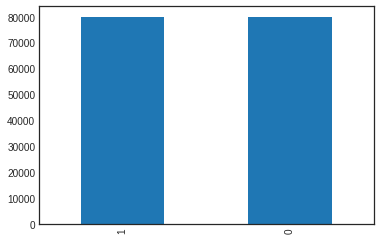

In [14]:
train_data['label'].value_counts().plot(kind='bar')

In [15]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,79909
1,1,80017


#### 불용어 제거 및 토큰화

* 불용어 사전: `'도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게'`

In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
mecab = Mecab()

mecab.morphs("오늘은 날씨가 참 좋네요")

['오늘', '은', '날씨', '가', '참', '좋', '네요']

In [18]:
# 형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행
train_data['reviews'] = train_data['reviews'].apply(mecab.morphs)

# 토큰화된 형태소 중에서 불용어 사전에 포함된 형태소 제거
train_data['reviews'] = train_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
test_data['reviews'] = test_data['reviews'].apply(mecab.morphs)
test_data['reviews'] = test_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
X_train = train_data['reviews'].values
y_train = train_data['label'].values
X_test = test_data['reviews'].values
y_test = test_data['label'].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(159926,)
(159926,)
(39982,)
(39982,)


In [21]:
X_train

array([list(['상다리', '안', '펴', '진다는', '글', '보', '긴', '했', '는데', '제것도', '그렇', '네요']),
       list(['생각', '보다', '냉감', '못', '느', '껬네요']),
       list(['재', '구매', '혈관', '건강', '지키', '려고', '남편', '한테', '열심히', '먹이', '있', '습니다']),
       ..., list(['깔끔', '포장', '되', '어', '오', '구', '맛있', '었', '어요']),
       list(['편하', '마음', '어요', '편해요']),
       list(['항상', '도움', '되', '제품', '예요'])], dtype=object)

In [22]:
from collections import Counter

negative_words = np.hstack(train_data[train_data.label == 0]['reviews'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['reviews'].values)

negative_word_count = Counter(negative_words)
print("부정적 단어 :", negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print("긍정적 단어 :", positive_word_count.most_common(20))

부정적 단어 : [('네요', 33811), ('는데', 21624), ('안', 21018), ('어요', 15837), ('너무', 14061), ('있', 14029), ('했', 12456), ('좋', 10374), ('배송', 10265), ('같', 9551), ('거', 9444), ('어', 9415), ('구매', 9370), ('없', 9287), ('아요', 9235), ('그냥', 8992), ('습니다', 8962), ('되', 8928), ('잘', 8590), ('않', 8502)]
긍정적 단어 : [('좋', 42221), ('아요', 22515), ('네요', 21300), ('잘', 19966), ('어요', 19899), ('구매', 17386), ('습니다', 14426), ('있', 13246), ('배송', 13060), ('는데', 12489), ('했', 10537), ('합니다', 10466), ('먹', 10268), ('재', 9966), ('너무', 8979), ('같', 8350), ('만족', 7824), ('거', 6983), ('어', 6793), ('쓰', 6713)]


긍정 리뷰의 평균 길이 : 13.612094929827412
부정 리뷰의 평균 길이 : 17.04042097886346


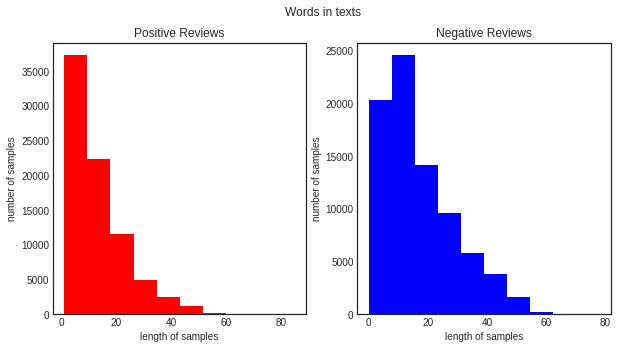

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['reviews'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['reviews'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

#### 정수 인코딩 및 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거
*   기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행



In [24]:
tokenizer = Tokenizer()

# 훈련 데이터에 대해서 단어 집합(vocaburary)을 생성
tokenizer.fit_on_texts(X_train)

In [25]:
threshold =  3
words_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수 카운트
words_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value

    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value

print("전체 단어 수: ", words_cnt)
print(f"빈도수가 {threshold-1}이하인 희귀 단어 수 : {rare_cnt}")
print(f"희귀 단어 비율 : {(rare_cnt / words_cnt) * 100}")
print(f"희귀 단어 등장 빈도 비율: {(rare_freq / words_freq) * 100}")

전체 단어 수:  41101
빈도수가 2이하인 희귀 단어 수 : 23624
희귀 단어 비율 : 57.4779202452495
희귀 단어 등장 빈도 비율: 1.1694157450256684


In [26]:
# vocab_size 는 Token화 진행시 최대 빈도숫자가 높은 단어만을 활용하고 나머지는 처리하겠다는 의미입니다.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = words_cnt - rare_cnt + 2 
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17479


In [27]:
# OOV: Out Of Vocabulary
# texts_to_sequences, 즉 등장횟수대로 토큰화 하고 vocab_size를 넘어가는 토큰은 전부 OOV

tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
print(X_train[0])
print(train_data['reviews'].values[0])
print()

print(test_data['reviews'].values[0])
print(X_test[0])

[7572, 10, 1168, 5936, 703, 41, 106, 14, 5, 8302, 342, 2]
['상다리', '안', '펴', '진다는', '글', '보', '긴', '했', '는데', '제것도', '그렇', '네요']

['그냥', '그래요', '잡', '아', '주', '그런', '거', '없', '음']
[42, 358, 367, 28, 38, 339, 16, 26, 75]


#### 패딩

- 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업
- max_len에 맞춰서 짧은 데이터에 zero token을 넣어서 길이를 맞춰줌

In [29]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train)) / len(X_train))

리뷰 최대 길이: 85
리뷰 평균 길이: 15.325100358915998


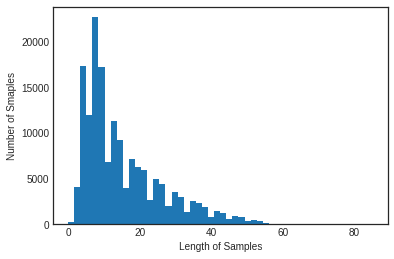

In [30]:
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Smaples')
plt.show()

In [31]:
max_len = 60
# 길이가 60 이상인 데이터는 데이터가 손실됨

In [32]:
# 앞부분에 0를 채워주는 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#### 모델 구축 및 학습

In [33]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [34]:
# 하이퍼 파라미터에 대한 정확한 이해가 부족

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, 100)) # 단어 집합의 크기, 임베딩 벡터의 차원
model.add(GRU(128)) # GRU 셀의 hidden_size는 128
model.add(Dense(1, activation='sigmoid')) # not softmax

In [36]:
# Overfitting을 방지
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [37]:
model.compile(optimizer = 'rmsprop', # RMS
              loss = 'binary_crossentropy', # BCE Loss
              metrics = ['acc'])
model.summary()

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1747900   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,836,349
Trainable params: 1,836,349
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2133/2133 [==============================] - 89s 27ms/step - loss: 0.3176 - acc: 0.8720 - val_loss: 0.2343 - val_acc: 0.9154

Epoch 00001: val_acc improved from -inf to 0.91540, saving model to best_model.h5
Epoch 2/15
2133/2133 [==============================] - 57s 27ms/step - loss: 0.2105 - acc: 0.9243 - val_loss: 0.2145 - val_acc: 0.9227

Epoch 00002: val_acc

In [38]:
final_model = load_model('best_model.h5')
final_model.evaluate(X_test, y_test)

1250/1250 [==============================] - 9s 7ms/step - loss: 0.2120 - acc: 0.9239


[0.21196328103542328, 0.9239157438278198]

#### 시각화

<function matplotlib.pyplot.show>

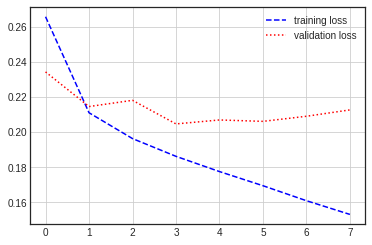

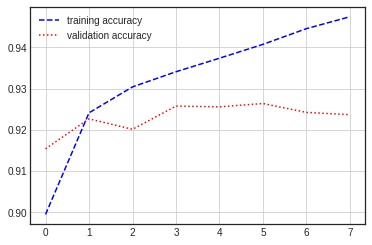

In [39]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label='training loss')
plt.plot(val_loss, 'r:', label='validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label='training accuracy')
plt.plot(val_acc, 'r:', label='validation accuracy')
plt.legend()
plt.grid()

plt.show

#### 감정 예측

In [42]:
def sentiment_predict(new_sentence):
    new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
    new_sentence = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sentence, maxlen = max_len)
    score = float(final_model.predict(new_pad))

    if score > 0.5:
        print("{} -> 긍정({:.2f}%)".format(new_sentence, score * 100))
    else:
        print("{} -> 부정({:.2f}%)".format(new_sentence, (1-score) * 100))

In [43]:
sentiment_predict('처음 써봤는데 너무 좋아요')
sentiment_predict('배송이 너무 느려요')
sentiment_predict('배송이 참 빨라요!')
sentiment_predict('추가 구매 의향 있습니다')
sentiment_predict('그저 그러네요')

[[151, 128, 134, 5, 13, 3, 6]] -> 긍정(97.96%)
[[12, 13, 797]] -> 부정(98.80%)
[[12, 371, 534, 1]] -> 긍정(74.43%)
[[363, 9, 3020, 8, 11]] -> 긍정(83.58%)
[[633, 553, 2]] -> 부정(99.49%)


In [46]:
sentiment_predict('상품은 너무 좋은데 배송이 너무 느려요')
sentiment_predict('배송은 너무 느린데 상품은 너무 좋아요')

[[89, 13, 3, 146, 12, 13, 797]] -> 부정(91.16%)
[[12, 13, 8754, 89, 13, 3, 6]] -> 긍정(75.77%)
